In [1]:
%matplotlib inline

In [2]:
# Import python modules
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from shapely.geometry import Point
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import plotting_functions as plots
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Load the lci data
root = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI"

infile = os.path.join(root, "Injune_lci_MGA55.nc")

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))


# Directory in which the grids are located
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI\grids\Injune_layer_grids.p"

# Run function
#lci.load_lci_layer_grids_from_pickle(infile)

# Create polylines
lci.create_flightline_polylines()

In [3]:

# Path to netcdf file
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\rjmcmc\Injune_petrel_rjmcmc_pmaps.nc"


# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                             inversion_type = 'stochastic',
                             netcdf_dataset = netCDF4.Dataset(infile))

In [4]:
# Read the interpretation csv into a dataframe
infile = r"C:\Users\symin\github\garjmcmctdem_utils\data\Surat_basin_AEM_interpretations.csv"

df_interp = pd.read_csv(infile, index_col=[0])

In [23]:
# Define the function for calculating conductance

def conductivity2conductance(layer_top_depth, log_cond,
                             depth_top, depth_bottom):
    """
    A function for estimating conductance from a layered earth model for a depth
    interval at a point. Our method is calculating a weighted average of conuctivity.

    Parameters
    ----------
    layer_top_depth: array
        an array of the layer top depth of the fiducial
    log_cond: array
        an array of log conductivity. must be the same shape as layer_top_depth
    depth_top: float
        a float of the top depth of the depth interval
    depth_bottom
        a float of the bottom depth of the depth interval

    Returns
    -------
    conductance: float

    """
    # do some checks
    if not depth_top < depth_bottom:
        print("Superposition error for fiducial ", str(rj.data['fiducial'][point_index]))
        return np.nan
    assert np.shape(log_cond) == np.shape(layer_top_depth)

    # In case of negative depth, whih can be cause by inconsistancy in DEM
    # during processing
    if depth_top < 0:
        depth_top = 0.

    # Create a layer_bottom_depth array

    layer_bottom_depth = np.nan*np.ones(shape = layer_top_depth.shape,
                                        dtype = layer_top_depth.dtype)

    layer_bottom_depth[:-1] = layer_top_depth[1:]

    layer_bottom_depth[-1] = layer_bottom_depth[-2] + (layer_bottom_depth[-2] - layer_bottom_depth[-3])

    # calculate thickness from the layer top depth
    thickness =  spatial_functions.depth_to_thickness(layer_top_depth)

    # Create a mask for depth intervals that fall outside our range
    # depths above our interval
    mask = np.greater(depth_top, layer_bottom_depth)
    #depth below our interval
    mask += np.less(depth_bottom,layer_bottom_depth)

    # Set thickness of AEM layers outside of the interval to zero
    thickness[mask] = 0

    # Now we deal with layers that only partially overlap with our interval.

    # The AEM layer that is at bisected by the top of our depth interval
    mask = np.logical_and(np.greater(depth_top, layer_top_depth),
                          np.less(depth_top, layer_bottom_depth))
    # assert that this is one or fewer layers. Zero layers may occur if there are no
    # partial layers
    assert np.sum(mask) <= 1

    # We make the thickness of this layer equal to the interval that overlaps
    thickness[mask] = layer_bottom_depth[mask] - depth_top

    # The AEM layer that is at bisected by the bottom of our depth interval
    mask = np.logical_and(np.less(depth_bottom, layer_bottom_depth),
                          np.greater(depth_bottom, layer_top_depth))
    # assert that this is one or fewer layers. Zero layers may occur if there are no
    # partial layers
    assert np.sum(mask) <= 1

    # We make the thickness of this layer equal to the interval that overlaps
    thickness[mask] = depth_bottom - layer_top_depth[mask]

    # Make sure our thickness sum is equal to the depth interval
    assert np.isclose(np.sum(thickness), depth_bottom - depth_top)

    return  np.divide(np.sum(10**log_cond*thickness), np.sum(thickness))


def rj2conductance(df_interp, point_index, upper_interface, lower_interface, layer):
    """
    A practical function for calculating conductance for an layer. It parses the dataframe to find
    the depth interval for the layer, extracts the conductivity profile and layer depths from the
    rj AEM inversion instance, calculates the conductance and writes it into a dataframe.
    Parameters
    ----------
    df_interp: dataframe
        dataframe with interpretation
    point_index: int
        integer that denotes the point index of our pmap within the rjmcmctdem
        stochastic inversion class
    upper_interface: string
    lower_interface: string

    Returns
    -------

    """
    # Read our layer dictionary

    # create a dataframe

    df = pd.DataFrame(data = {'fiducial': rj.data['fiducial'][point_index],
                              'rj_point_index': point_index,
                              'layer': layer,
                              'conductance_p10': np.nan,
                              'conductance_p50': np.nan,
                              'conductance_p90': np.nan,
                              },
                      index = [0])

    upper_depth = df_interp[df_interp['interface'] == upper_interface]['depth_mBGL'].values[0]
    lower_depth = df_interp[df_interp['interface'] == lower_interface]['depth_mBGL'].values[0]

    # Calculate the layer top depth from layer centre depth
    layer_top_depth = rj.data['layer_centre_depth'][:] - rj.data['layer_centre_depth'][0]

    # Iterate through the percentile conductivity models
    for item in ['conductivity_p10', 'conductivity_p50', 'conductivity_p90']:
        # Note the profiles are in log conductivity
        log_conductivity = rj.data[item][point_index]
        # Calculate conductance
        cond = conductivity2conductance(layer_top_depth, log_conductivity,
                                        upper_depth, lower_depth)
        # Write it into the dataframe
        column_name = item.replace('conductivity', 'conductance')
        df.at[0, column_name] = cond

    return df

In [24]:
# Create a dataframe for appending the results into

df_conductance = pd.DataFrame(columns = ['fiducial','rj_point_index','layer',
                                         'conductance_p10','conductance_p50',
                                         'conductance_p90'])

# Iterate through our rj models on a point

for i in range(rj.data.dimensions['point'].size):
    point_index = i
    # Get our fiducial data using a mask
    fid_mask = df_interp['fiducial'] == rj.data['fiducial'][point_index]

    df_site_interp = df_interp[fid_mask]

    # Get an array of the interfaces interpreted at this fiducial
    interfaces = df_site_interp["interface"].values
    # Use some logic for dealing with interface

    if np.logical_and('Top_intra_Precipice_Sst' in interfaces,
                      'Top_Precipice_SSt' in interfaces):
        layer = "upperPrecipice"
        # Now calculate the conductance

        df_temp = rj2conductance(df_site_interp, point_index,
                                     upper_interface = 'Top_Precipice_SSt',
                                     lower_interface = 'Top_intra_Precipice_Sst',
                                     layer = layer)
        df_conductance = df_conductance.append(df_temp)
    if np.logical_and('Base_lower_Precipice' in interfaces,
                      'Top_Precipice_SSt' in interfaces):
        layer = "Precipice"
        # Now calculate the conductance

        df_temp = rj2conductance(df_site_interp, point_index,
                                 upper_interface = 'Top_Precipice_SSt',
                                 lower_interface = 'Base_lower_Precipice',
                                 layer = layer)

        df_conductance = df_conductance.append(df_temp)
    if np.logical_and('Top_intra_Precipice_Sst' in interfaces,
                      'Top_Lower_Precipice_Sst' in interfaces):
        layer = "intraPrecipice"
        # Now calculate the conductance

        df_temp = rj2conductance(df_site_interp, point_index,
                                     upper_interface = 'Top_intra_Precipice_Sst',
                                     lower_interface = 'Top_Lower_Precipice_Sst',
                                     layer = layer)
        df_conductance = df_conductance.append(df_temp)

    if np.logical_and('Base_lower_Precipice' in interfaces,
                      'Top_Lower_Precipice_Sst' in interfaces):
        layer = "lowerPrecipice"
        # Now calculate the conductance

        df_temp = rj2conductance(df_site_interp, point_index,
                                     upper_interface = 'Top_Lower_Precipice_Sst',
                                     lower_interface = 'Base_lower_Precipice',
                                     layer = layer)

        df_conductance = df_conductance.append(df_temp)

df_conductance.reset_index(drop = True, inplace = True)

inds = df_conductance['rj_point_index'].astype('int').values

df_conductance['easting'] = rj.data['easting'][inds]
df_conductance['northing'] = rj.data['northing'][inds]

df_site_interp

Superposition error for fiducial  169353.0
Superposition error for fiducial  169353.0
Superposition error for fiducial  169353.0
Superposition error for fiducial  167072.0
Superposition error for fiducial  167072.0
Superposition error for fiducial  167072.0
Superposition error for fiducial  170017.0
Superposition error for fiducial  170017.0
Superposition error for fiducial  170017.0
Superposition error for fiducial  167082.0
Superposition error for fiducial  167082.0
Superposition error for fiducial  167082.0
Superposition error for fiducial  167077.0
Superposition error for fiducial  167077.0
Superposition error for fiducial  167077.0
Superposition error for fiducial  167092.0
Superposition error for fiducial  167092.0
Superposition error for fiducial  167092.0
Superposition error for fiducial  170658.0
Superposition error for fiducial  170658.0
Superposition error for fiducial  170658.0
Superposition error for fiducial  167087.0
Superposition error for fiducial  167087.0
Superpositi

,line,easting,northing,depth_mBGL,elevation_mAHD,interface,fiducial
2733,200901,678611.2258,7151545.323,158.096984,318.80301,Top_intra_Precipice_Sst,171934
4356,200901,678611.2258,7151545.323,94.375424,382.52457,Top_Precipice_SSt,171934


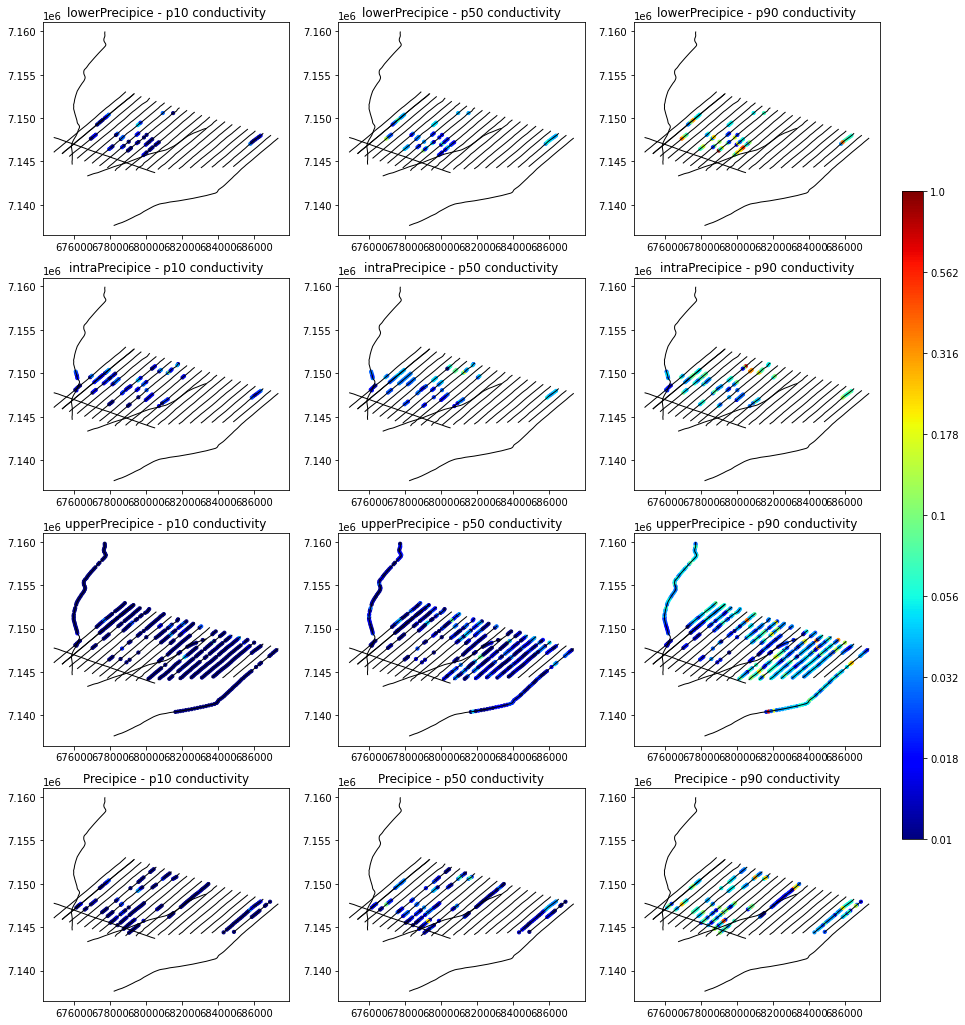

In [28]:
# Scatter plots for the points

fig, ax_array = plt.subplots(4,3, figsize = (15,18))

for i in range(4):
    for j in range(3):
        for lin in rj.data['line'][:]:
            linestring  = lci.flight_lines[lin]
            ax_array[i,j].plot(linestring.xy[0],
                     linestring.xy[1],
                     'k', linewidth = 1)

interface_list = ['lowerPrecipice', 'intraPrecipice',
                  'upperPrecipice', 'Precipice']
percentiles = ['p10', 'p50', 'p90']

# plot the p10 models
for i in range(4):
    for j in range(3):
        # subset by condition
        layer_mask = df_conductance['layer'] == interface_list[i]

        df_ss = df_conductance[layer_mask]
        im = ax_array[i, j].scatter(df_ss['easting'].values,
                                   df_ss['northing'].values,
                                   c = np.log10(df_ss['conductance_' + percentiles[j]].values),
                                   cmap = 'jet',
                                   vmin = np.log10(0.01),
                                   vmax = np.log10(1.), s = 10)
        ax_array[i,j].set_title(interface_list[i] + " - "  + percentiles[j] + " conductivity")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_yticklabels([np.round(10**x,3) for x in cbar.ax.get_yticks()])
plt.savefig(r'C:\temp\Surat_conductance.png', dpi = 300)
plt.show()

In [30]:
# Now lets write out a geodataframe

easting = df_conductance['easting'].values
northing = df_conductance['northing'].values
geometry = []
for i in range(len(easting)):
    geometry.append(Point(easting[i], northing[i]))

df_conductance['geometry'] = geometry

gdf = gpd.GeoDataFrame(df_conductance,
                       crs = 'EPSG:28355')

In [33]:
# For convenience we are going to create a geopackage where each geological layer
# is its own vector layer

outfile = r"C:\temp\SuratConductance.gpkg"

for item in interface_list:
    mask = gdf['layer'] == item
    gdf[mask].to_file(outfile, layer=item, driver="GPKG")